# Compare runtime for QAOA depth _p_=1 angles search  #

In [1]:
from qcware import forge
# this line is for internal tracking; it is not necessary for use!
forge.config.set_environment_source_file('analytical_angles_runtime.ipynb')


## Table of Contents
1. [Introduction](#introduction)
2. [Example QAOA _p_ = 1 ](#example)  
    2.1 [Angle Search Using Circuit Simulation](#simulation)  
    2.1 [Analytical Angle Search Using `find_optimal_qaoa_angles`](#analytical)

## 1. Introduction <a name="introduction"></a>

This notebook explores the use of the analytical angle determination functionality for the Quantum Approximate Optimization Algorithm (QAOA) [Farhi, Goldstone, Gutmann, arxiv:1411.4028] with depth $p=1$.

QAOA generates approximate solutions for combinatorial optimization problems. For each $p$ step the circuit applies a couple of unitary operators, the cost operator dependent on the angle $\gamma$, $U_C(\gamma)$, and the mixing operator dependent on the angle $\beta$, $U_B(\beta)$. The total number of $\beta$, $\gamma$ angles is thus equal to $2p$. In order for the QAOA circuit to return the best possible solution, we need to classicaly optimize the angles present in the circuit by optimizing the expectation value of the cost function. 

In this notebook we will examine an example of depth 1 QAOA ($p=1$), optimizing two angles $(\beta, \gamma)$. We use an exhaustive search approach that scans a grid of possible $(\beta, \gamma)$ pairs and calculates the expectated performance of the algorithm.

The normal approach for calculating the expected performance for a given $(\beta, \gamma)$, is to simulate the QAOA circuit. Each circuit simulation has runtime that is exponential in the number of qubits. So for circuits on large numbers of qubits this is very expensive.

We present an algorithm that calculates this expectation value analytically, which is no longer exponential in the number of qubits.


### QAOA Simulation Code ###
Below is a class used for simulating a QAOA circuit using `quasar`, QC Ware's circuit library.


In [2]:
import quasar
import qubovert as qv
I, X, Y, Z = quasar.Pauli.IXYZ()

class QAOA:
    def __init__(self, cost_quso):
        self.cost_quso = qv.QUSO(cost_quso)
        self.num_qubits = self.cost_quso.num_binary_variables
        self.backend = quasar.QuasarSimulatorBackend()
        cost_pauli = quasar.Pauli.zero()
        I, X, Y, Z = quasar.Pauli.IXYZ()
        for qubits, coeff in cost_quso.items():
            if len(qubits) == 0:
                cost_pauli += coeff
            elif len(qubits) == 1:
                cost_pauli += Z[qubits[0]]*coeff
            elif len(qubits) == 2:
                cost_pauli += Z[qubits[0]]*Z[qubits[1]]*coeff
            else:
                raise ValueError("cost_quso keys must be tuples length <= 2")
        self.cost_pauli = cost_pauli
    
    def cost_circuit(self, gamma):
        """returns UC(gamma) circuit for quadratic spin function 
        described by dict cost_quso"""
        circuit = quasar.Circuit()
        for qubits, coeff in sorted(self.cost_quso.items()):
            # skip identity
            if len(qubits) == 0:
                continue
            elif len(qubits) == 1:
                circuit.Rz(qubits[0], theta=coeff*gamma)
            elif len(qubits) == 2:
                circuit.CX(qubits[0], qubits[1])
                circuit.Rz(qubits[1], theta=coeff*gamma)
                circuit.CX(qubits[0], qubits[1])
            else:
                raise ValueError("cost_quso keys must be tuples length <= 2")
        return circuit

    def mixing_circuit(self, beta):
        """returns UB(beta) circuit"""
        circuit = quasar.Circuit()
        for i in range(self.num_qubits):
            circuit.Rx(i, theta=beta)
        return circuit

    def initial_state_circuit(self, num_qubits):
        """returns circuit that prepares the initial state"""
        circuit = quasar.Circuit()
        for i in range(num_qubits):
            circuit.H(i)
        return circuit

    def get_circuit(self, betas, gammas):
        """returns a QAOA circuit for parameters `betas`, `gammas`
        betas, gammas : float or list of floats"""
        if isinstance(betas, float):
            betas = [betas]
        if isinstance(gammas, float):
            gammas = [gammas]
        p = len(betas)
        circuit = self.initial_state_circuit(self.num_qubits)
        for i in range(p):
            beta, gamma = betas[i], gammas[i]
            circuit = quasar.Circuit.join_in_time(
                [circuit, 
                 self.cost_circuit(gamma),
                 self.mixing_circuit(beta)])
        return circuit

    def expectation_value(self, betas, gammas):
        circuit = self.get_circuit(betas, gammas)
        return self.backend.run_pauli_expectation_value(circuit,self.cost_pauli).real


### Heatmap Visualization Code ###
below is code to visualize a grid of values for $\beta, \gamma$ as a heatmap

In [3]:
import matplotlib.pyplot as plt

def heatmap(vals, colors):
    fig, ax = plt.subplots(1,1)
    img = ax.imshow(vals, cmap=colors,extent=[0, np.pi,np.pi,0])
    ax.invert_yaxis()
    x_label_list = [r"0",r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$",r"$\pi$"]
    ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4,np.pi])
    ax.set_xticklabels(x_label_list)
    ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4,np.pi])
    ax.set_yticklabels(x_label_list)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\gamma$")
    fig.colorbar(img)

***
# 2.  QAOA$_{p=1}$ Example <a name="example"></a> #
First, we specify the quadratic spin cost function that we want to minimize. 
Assuming $4$ spins, $z_0z_1z_2z_3$, and cost function $z_0 + z_1 -2 z_2 -4 z_3-2 z_0z_1  -6 z_2z_3$

In [4]:
cost_dict = {(0,): 1, (1,): 1, (0, 1): -2, (2,): -2, (3,): -4, (2, 3): -6}


Next, specify `num_evals` as the number of different angles between $0$ and $\pi$ to try for $\beta$ and $\gamma$.

We will evaluate the expectation value of the cost function for a given number `num_evals` of points in the range $[ 0, \pi ]$ for $\beta$, and $\gamma$. 
This means that the total number of evaluations will be `num_evals` * `num_evals`. 


In [5]:
num_evals = 150

## 2.1 Angle search Using Circuit Simulation <a name="simulation"></a> ## 
Calculate the expectations of all `num_evals`*`num_evals` , $(\beta, \gamma)$ pairs, and display results as a heatmap.

calculated in 67.18943095207214 seconds


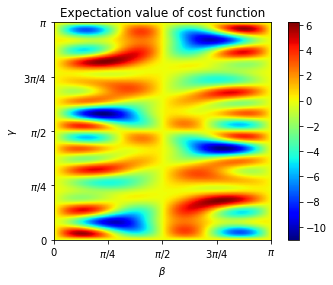

In [6]:
import time
import numpy as np
tic = time.time()
qaoa = QAOA(cost_quso=cost_dict)
simulated_expectations = np.zeros((num_evals, num_evals))
betas = gammas = np.linspace(0, np.pi, num_evals)
for beta_i, beta in enumerate(gammas):
    for gamma_i, gamma in enumerate(betas):
        simulated_expectations[gamma_i][beta_i] = qaoa.expectation_value(beta, gamma)
toc = time.time()
print(f"calculated in {toc-tic} seconds")

heatmap(simulated_expectations, 'jet')
plt.title("Expectation value of cost function")
plt.show()

## 2.2 Analytical Angle Search Using `find_optimal_qaoa_angles` <a name="analytical"></a> ##

Next, we will call the `analytical_angle_determination` function to evaluate the expectation values of the cost function for the `num_evals`*`num_evals` points. 
We also can specify the number of minimum values that the function should return using `num_min_vals`. 
A higher number will not affect speed. 
`fastmath_flag_in` determines if the fastmath flag should be enabled. 
Setting it to `True` can affect precision. Lastly, `precision` determines the minimum distance between peaks.

The function returns a list of peak expectation values of the cost function in increasing order, and a list of the $\beta$,$\gamma$ pairs corresponding to those expectation values.



calculated in 2.9968101978302 seconds

Optimal Expectations:
[-11.023612333401879, -11.023612333401875, -10.08734391997669]
BG pairs:
[[0.6957889769695516, 1.8132682430115585],
 [2.445803676620242, 1.3283244105782348],
 [0.8855496070521565, 0.25301417344347327]]


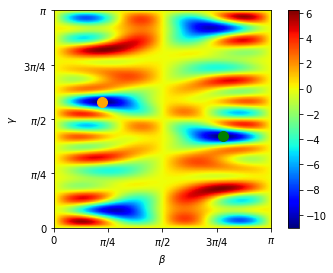

In [7]:
tic = time.time()
opt_expectations, opt_bg_pairs, analytical_expectations = \
                forge.optimization.find_optimal_qaoa_angles(cost_dict,
                                               num_evals=num_evals,
                                               num_min_vals=3,
                                               fastmath_flag_in=True,
                                               precision=10)
toc = time.time()
import pprint
print(f"calculated in {toc-tic} seconds")
print()
print("Optimal Expectations:")
pprint.pprint(opt_expectations)
print("BG pairs:")
pprint.pprint(opt_bg_pairs)
heatmap(analytical_expectations, 'jet')
plt.scatter(opt_bg_pairs[0][0], opt_bg_pairs[0][1], s=100, color='orange')
plt.scatter(opt_bg_pairs[1][0],opt_bg_pairs[1][1], s=100, color='green')
plt.show()

Calculating these expectation values is **much** faster with `find_optimal_qaoa_angles`! 

Verify the two calculations give the same result.

In [8]:
print(np.allclose(analytical_expectations, simulated_expectations))

True


Alternatively we can make a 3D plot of the expectation value landscape.

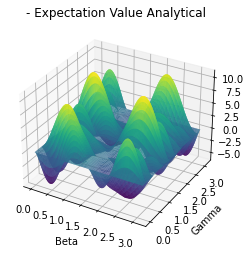

In [9]:
# Define the linear space to make a meshgrid with the number of points used.

def threeplot(vals, colors, n_x):
    x = np.linspace(0, np.pi, num_evals)
    y = np.linspace(0, np.pi, num_evals)

    X, Y = np.meshgrid(x, y)

    # Make a 3D plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_surface(X, Y, vals, rstride=1, cstride=1,
                     cmap=colors, edgecolor='none')

    ax.set_title('- Expectation Value Analytical')

    plt.xlabel('Beta')
    plt.ylabel('Gamma')
    plt.show(fig)
    
threeplot(-analytical_expectations, 'viridis', num_evals)

<br><a href="#top">Back to Table of Contents</a>